In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from PIL import Image
from pathlib import Path
import subprocess
import shutil
import datetime

from typing import Tuple
import sys

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

In [ ]:
sys.path.clear()
sys.path.append('/content/drive/MyDrive/Code/')
print(sys.path)

from loadcbis import get_datasets, get_cross_datasets

# Helper Functions

# TODO Load Images

In [ ]:
BATCH_SIZE = 16
IMG_WIDTH = 224
IMG_SIZE = (IMG_WIDTH, IMG_WIDTH)

In [ ]:
train_dataset, val_dataset, test_dataset = get_datasets(IMG_WIDTH, BATCH_SIZE)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CBIS-DDSM/test_two_class_v2.csv')

In [ ]:
import shutil
for index, row in df[['ROI_path', 'pathology']].iterrows():
    label = row['pathology']
    shutil.copy2(row['ROI_path'], f'/content/drive/MyDrive/Data/Test/{label}/{index}.jpg')

# Create datasets

In [ ]:
BATCH_SIZE = 32
IMG_WIDTH = 160
IMG_SIZE = (IMG_WIDTH, IMG_WIDTH)

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
def process_img(img: str) -> tf.Tensor:
  img = tf.image.decode_jpeg(img, channels=3) 
  img = tf.image.convert_image_dtype(img, tf.float32) 
  img = tf.image.resize_with_pad(
      img, 
      IMG_WIDTH, IMG_WIDTH, 
      method=tf.image.ResizeMethod.BILINEAR,
      antialias=False
      )
  return preprocess_input(img)
  
@tf.function
def image_process(file_path: tf.Tensor, label: tf.Tensor) -> (tf.Tensor, tf.Tensor):
  print(file_path)
  img = tf.io.read_file(file_path)
  img = process_img(img)
  image = tf.ensure_shape(img,[IMG_WIDTH, IMG_WIDTH, 3])
  label = tf.ensure_shape(label,())
  return img, label
  
def fix_shape(tensor: tf.Tensor):
  print(tensor)
  tensor[0].set_shape((IMG_WIDTH, IMG_WIDTH, 3))
  tensor[1].set_shape(())
  return tensor

In [ ]:
shape = tf.TensorShape([IMG_WIDTH, IMG_WIDTH, 3])

train_df = pd.read_csv('/content/drive/MyDrive/CBIS-DDSM/train_two_class.csv')
train_df['pathology'] = train_df['pathology'].apply(lambda x: 1 if x.upper() == 'MALIGNANT' else 0)

train_pre = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(train_df["ROI_path"]), 
    tf.convert_to_tensor(train_df["pathology"])
    ))

train_dataset = train_pre.map(image_process,
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)


test_df = pd.read_csv('/content/drive/MyDrive/CBIS-DDSM/test_two_class.csv')
test_df['pathology'] = test_df['pathology'].apply(lambda x: 1 if x == 'Malignant' else 0)

test_pre = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(test_df["ROI_path"]), 
    tf.convert_to_tensor(test_df["pathology"])
    ))

test_dataset = test_pre.map(image_process,
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)


# Create val dataset by splitting train dataset
train_batches = tf.data.experimental.cardinality(train_dataset)
val_dataset = train_dataset.take(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)

# Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#Base Model (ResNet50)



In [ ]:
input_tensor = tf.keras.Input(shape=(IMG_WIDTH, IMG_WIDTH, 3))
layers_to_freeze = 143
base_model = tf.keras.applications.resnet50.ResNet50(input_tensor=input_tensor,
                                               include_top=False,
                                               weights='imagenet')
for layer in base_model.layers[:layers_to_freeze]:
    layer.trainable = False

#Build Model

In [ ]:
model = tf.keras.Sequential()
model.add(base_model)

## Add a prediction head

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='softmax'))

In [ ]:
# model = tf.keras.Sequential()
# model.add(layers.Lambda(lambda image: preprocess_input(image)))
# model.add(base_model)
# model.add(layers.Flatten())
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(3, activation='softmax'))

NameError: ignored

In [ ]:
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.h5",
                                                 monitor="val_loss",
                                                 mode="max",
                                                 save_best_only=True,
                                                 )

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['binary_accuracy', 'binary_crossentropy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1)                 51201     
                                                                 
Total params: 23,638,913
Trainable params: 15,027,201
Non-trainable params: 8,611,712
_________________________________________________________________


#Training

##Frozen training

In [ ]:
initial_epochs = 100

In [ ]:
history = model.fit(train_dataset,
                    batch_size = BATCH_SIZE,
                    epochs=initial_epochs,
                    verbose=1,
                    validation_data=val_dataset,
                    callbacks=[check_point, early_stop])

Epoch 1/100
30/30 [==============================] - 270s 8s/step - loss: 1.3268 - binary_accuracy: 0.5250 - binary_crossentropy: 1.3268 - val_loss: 0.7120 - val_binary_accuracy: 0.5223 - val_binary_crossentropy: 0.7120
Epoch 2/100
30/30 [==============================] - 263s 8s/step - loss: 0.8223 - binary_accuracy: 0.5250 - binary_crossentropy: 0.8223 - val_loss: 0.7188 - val_binary_accuracy: 0.5223 - val_binary_crossentropy: 0.7188
Epoch 3/100
30/30 [==============================] - 259s 8s/step - loss: 0.7233 - binary_accuracy: 0.5250 - binary_crossentropy: 0.7233 - val_loss: 0.7125 - val_binary_accuracy: 0.5223 - val_binary_crossentropy: 0.7125
Epoch 4/100
30/30 [==============================] - 258s 8s/step - loss: 0.7354 - binary_accuracy: 0.5250 - binary_crossentropy: 0.7354 - val_loss: 0.7156 - val_binary_accuracy: 0.5223 - val_binary_crossentropy: 0.7156


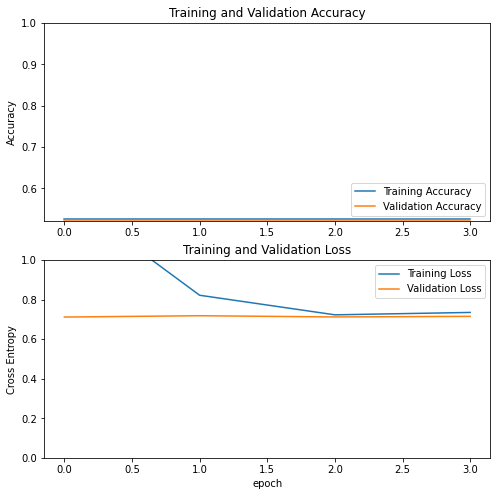

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Unfrozen training (all layers)

In [ ]:
model.trainable = True

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['binary_accuracy', 'binary_crossentropy'])

In [ ]:
fine_tune_epochs = 100

In [ ]:
history_fine = model.fit(train_dataset,
                         epochs=initial_epochs + fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=[check_point, early_stop])

Epoch 4/200
30/30 [==============================] - 550s 16s/step - loss: 0.0000e+00 - binary_accuracy: 0.5250 - binary_crossentropy: 38.8423 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.5223 - val_binary_crossentropy: 1.0770


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


NameError: ignored

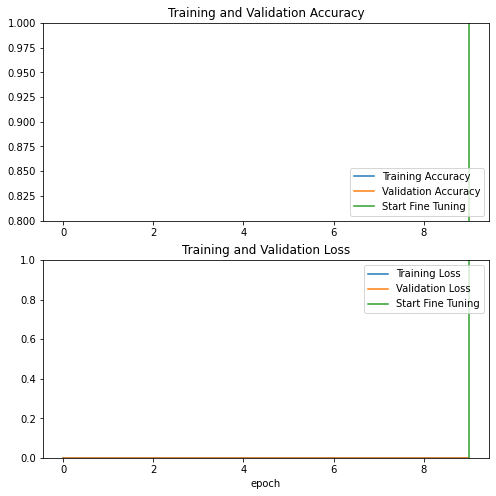

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

9/9 [==============================] - 2s 152ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test accuracy : 0.0
